# **Car Body Damage Detection**
### -Detect scratch, dent, repaint etc. on car body

### Source/Useful Links

For Segmentation: https://www.tensorflow.org/tutorials/images/segmentation

U-Net - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

U-Net++ - https://jinglescode.github.io/datascience/2019/12/02/biomedical-image-segmentation-u-net-nested/

Data Preprocessing:
1. https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c

2. https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/

Training and predictions: 
Google Colab https://colab.research.google.com/

In [0]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import datetime
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pathlib
from PIL import Image
import numpy as np
#from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from IPython.display import clear_output
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

# for TensorBoard
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x

import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/CS2/references/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join("/content/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

1.0.1


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## 4. **Data preparation**

In [0]:
def display1(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [0]:
def create_mask(pred_mask):
  '''
  as predicted mask has 4dim with bacth size we need to remove that
  tf.argmax Returns the index with the largest value across axes of a tensor.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=3):
  '''
  Takes input image and predicts mask and plots the Input, True, Predicted images
  '''
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display1([image[0], mask[0], create_mask(pred_mask)])
  else:
    display1([sample_image, sample_mask,
             model.predict(sample_image[tf.newaxis, ...])[0]])

### Tfdata Generator

In [0]:
TRAIN_LENGTH = 44
BATCH_SIZE = 8
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
OUTPUT_CHANNELS = 3

In [0]:
data_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CS2/references/new")
val_data_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/CS2/references/new")
print(val_data_root)

/content/drive/My Drive/Colab Notebooks/CS2/references/new


In [0]:
##Getting all image paths
import random

all_image_paths = list(data_root.glob('images/*/*'))
all_image_paths = [str(path) for path in all_image_paths]

all_mask_paths = list(data_root.glob('masks/*/*'))
all_mask_paths = [str(path) for path in all_mask_paths]

val_all_image_paths = list(data_root.glob('v_images/*/*'))
val_all_image_paths = [str(path) for path in val_all_image_paths]

val_all_mask_paths = list(data_root.glob('v_masks/*/*'))
val_all_mask_paths = [str(path) for path in val_all_mask_paths]

# ##shuffling the images 
# random.shuffle(all_image_paths)

print("image_count = ", len(all_image_paths), ", mask_count = ", len(all_mask_paths))
print("val_image_count = ", len(val_all_image_paths), ", val_mask_count = ", len(val_all_mask_paths))

image_count =  43 , mask_count =  43
val_image_count =  5 , val_mask_count =  5


In [0]:
def tfdata_generator(images, mask, is_training, batch_size=1):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, mask):
        #reading path 
        image_string = tf.io.read_file(filename)
        mask_string = tf.io.read_file(mask)
        
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)
        mask = tf.image.decode_jpeg(mask_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        
        #resize the image
        image = tf.image.resize(image, [256, 256])
        mask = tf.image.resize(mask, [256, 256])
        
        image = tf.image.resize_with_crop_or_pad(image, 300, 300) # Add 6 pixels of padding
        image = tf.image.random_crop(image, size=[256, 256, 3], seed = 1) # Random crop back to 256X256
        #image = tf.image.random_brightness(image, max_delta=0.5, seed = 1)
        image = tf.image.random_flip_left_right(image, seed=1)
        image = tf.image.random_flip_up_down(image, seed=1)
        #image = tf.image.random_jpeg_quality(image, 90, 100, seed=1)

        mask = tf.image.resize_with_crop_or_pad(mask, 300, 300) # Add 6 pixels of padding
        mask = tf.image.random_crop(mask, size=[256, 256, 3], seed = 1) # Random crop back to 256X256
        #mask = tf.image.random_brightness(mask, max_delta=0.5, seed = 1)
        mask = tf.image.random_flip_left_right(mask, seed=1)
        mask = tf.image.random_flip_up_down(mask, seed=1)
        #mask = tf.image.random_jpeg_quality(mask, 90, 100, seed=1)

        #image, mask = normalize(image, mask)
        return image, mask
    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, mask))
    
    if is_training:
        dataset = dataset.shuffle(100)  # depends on sample size

    # Transform and batch data at the same time
    dataset = dataset.apply(tf.data.experimental.map_and_batch( parse_function, batch_size, num_parallel_batches=BATCH_SIZE,  # cpu cores
        drop_remainder=True if is_training else False))
    
    #repeat the dataset indefinitely
    dataset = dataset.repeat()

    
    #prefetch the data into CPU/GPU
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [0]:
#creating a generator
tf_image_generator = tfdata_generator(all_image_paths, all_mask_paths, is_training=True, batch_size=BATCH_SIZE)
val_tf_image_generator = tfdata_generator(val_all_image_paths, val_all_mask_paths, is_training=True, batch_size=4)
tf_image_generator

<PrefetchDataset shapes: ((8, 256, 256, 3), (8, 256, 256, 3)), types: (tf.float32, tf.float32)>

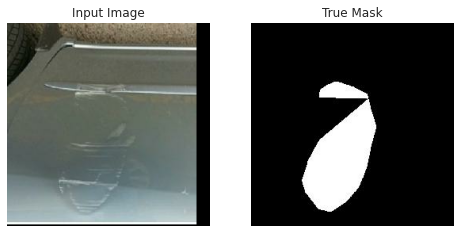

In [0]:
for image, mask in val_tf_image_generator.take(5):
  sample_image, sample_mask = image[0], mask[0]
display1([sample_image, sample_mask])

## 5. Define Custom model

<img src="images/Nested_Unet.png" width="800" />

In [0]:
#https://jinglescode.github.io/datascience/2019/12/02/biomedical-image-segmentation-u-net-nested/
#Unet++

class conv_block_nested(tf.keras.Model):

    def __init__(self, in_ch):
        super(conv_block_nested, self).__init__()
        self.activation = layers.Activation('relu')
        self.conv1 = layers.Conv2D(in_ch, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(in_ch, 3, padding='same')
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

class Nested_UNet(tf.keras.Model):

    def __init__(self, out_ch=3):
        super(Nested_UNet, self).__init__()

        n1 = 32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.pool = layers.MaxPooling2D(3, strides=2, padding='same') #2 or 3 ?
        self.Up = layers.UpSampling2D(2)

        self.conv0_0 = conv_block_nested(filters[0])
        self.conv1_0 = conv_block_nested(filters[0])
        self.conv2_0 = conv_block_nested(filters[1])
        self.conv3_0 = conv_block_nested(filters[2])
        self.conv4_0 = conv_block_nested(filters[3])

        self.conv0_1 = conv_block_nested(filters[0])
        self.conv1_1 = conv_block_nested(filters[1])
        self.conv2_1 = conv_block_nested(filters[2])
        self.conv3_1 = conv_block_nested(filters[3])

        self.conv0_2 = conv_block_nested(filters[0])
        self.conv1_2 = conv_block_nested(filters[1])
        self.conv2_2 = conv_block_nested(filters[2])

        self.conv0_3 = conv_block_nested(filters[0])
        self.conv1_3 = conv_block_nested(filters[1])

        self.conv0_4 = conv_block_nested(filters[0])

        self.final = tf.keras.layers.Conv2D(out_ch, 3, activation='sigmoid', padding='same')

    def call(self, x):
        
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(tf.keras.layers.concatenate([x0_0, self.Up(x1_0)]))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(tf.keras.layers.concatenate([x1_0, self.Up(x2_0)]))
        x0_2 = self.conv0_2(tf.keras.layers.concatenate([x0_0, x0_1, self.Up(x1_1)]))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(tf.keras.layers.concatenate([x2_0, self.Up(x3_0)]))
        x1_2 = self.conv1_2(tf.keras.layers.concatenate([x1_0, x1_1, self.Up(x2_1)]))
        x0_3 = self.conv0_3(tf.keras.layers.concatenate([x0_0, x0_1, x0_2, self.Up(x1_2)]))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(tf.keras.layers.concatenate([x3_0, self.Up(x4_0)]))
        x2_2 = self.conv2_2(tf.keras.layers.concatenate([x2_0, x2_1, self.Up(x3_1)]))
        x1_3 = self.conv1_3(tf.keras.layers.concatenate([x1_0, x1_1, x1_2, self.Up(x2_2)]))
        x0_4 = self.conv0_4(tf.keras.layers.concatenate([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)]))

        output = self.final(x0_4)
        
        return output

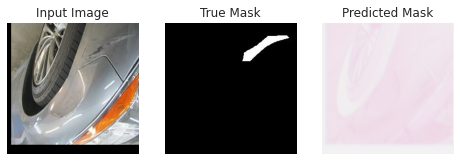

Model: "nested_u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
up_sampling2d (UpSampling2D) multiple                  0         
_________________________________________________________________
conv_block_nested (conv_bloc multiple                  10400     
_________________________________________________________________
conv_block_nested_1 (conv_bl multiple                  18752     
_________________________________________________________________
conv_block_nested_2 (conv_bl multiple                  55936     
_________________________________________________________________
conv_block_nested_3 (conv_bl multiple                  222464    
_________________________________________________________________
conv_block_nested_4 (conv_bl multiple                 

In [0]:
tf.keras.backend.clear_session()
model = Nested_UNet(3)
model.compile()
show_predictions()
model.summary()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  '''
  To check the predicted mask at each epoch
  '''
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [0]:
# Metrics
# For image segmentation
# COMPETITION METRIC
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    
dependencies = {'dice_coef':dice_coef,
    'dice_loss':sm.losses.dice_loss }

### Compile and fit the model

In [0]:
# https://www.tensorflow.org/tensorboard/r2/scalars_and_keras
logdir = '/content/' + datetime.now().strftime("%Y%m%d-%H%M%S")+'_damage_2020'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0,write_images=True)
#train_writer = tf.summary.create_file_writer('./logs/1/train')
# https://keras.io/callbacks/
mc = ModelCheckpoint(filepath = ROOT_DIR +'/car_damage_new.h5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=10)

In [0]:
model = Nested_UNet(OUTPUT_CHANNELS)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.7028 - dice_coef: 0.2914

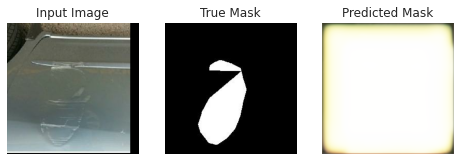


Sample Prediction after epoch 1


Epoch 00001: val_dice_coef improved from -inf to 0.27480, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 61s 1s/step - loss: 0.7028 - dice_coef: 0.2914 - val_loss: 0.7251 - val_dice_coef: 0.2748
Epoch 2/50
49/49 [==============================] - ETA: 0s - loss: 0.4590 - dice_coef: 0.5408

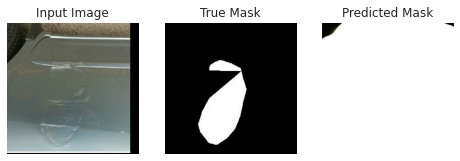


Sample Prediction after epoch 2


Epoch 00002: val_dice_coef did not improve from 0.27480
49/49 [==============================] - 59s 1s/step - loss: 0.4590 - dice_coef: 0.5408 - val_loss: 0.7671 - val_dice_coef: 0.2329
Epoch 3/50
49/49 [==============================] - ETA: 0s - loss: 0.3570 - dice_coef: 0.6430

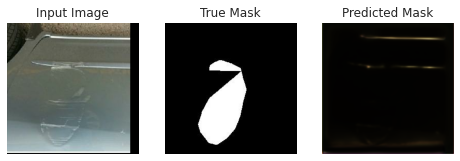


Sample Prediction after epoch 3


Epoch 00003: val_dice_coef did not improve from 0.27480
49/49 [==============================] - 59s 1s/step - loss: 0.3570 - dice_coef: 0.6430 - val_loss: 0.9964 - val_dice_coef: 0.0036
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 0.3247 - dice_coef: 0.6753

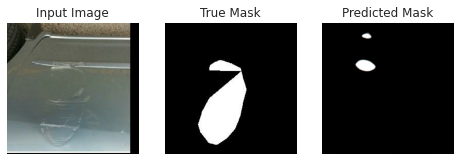


Sample Prediction after epoch 4


Epoch 00004: val_dice_coef improved from 0.27480 to 0.43766, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 59s 1s/step - loss: 0.3247 - dice_coef: 0.6753 - val_loss: 0.5623 - val_dice_coef: 0.4377
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 0.2840 - dice_coef: 0.7160

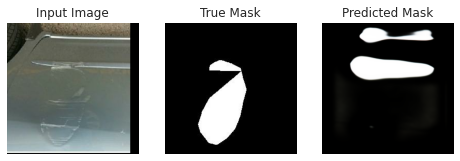


Sample Prediction after epoch 5


Epoch 00005: val_dice_coef did not improve from 0.43766
49/49 [==============================] - 59s 1s/step - loss: 0.2840 - dice_coef: 0.7160 - val_loss: 0.6042 - val_dice_coef: 0.3958
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 0.2495 - dice_coef: 0.7505

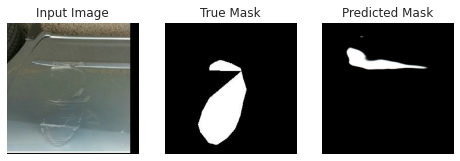


Sample Prediction after epoch 6


Epoch 00006: val_dice_coef improved from 0.43766 to 0.54903, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 59s 1s/step - loss: 0.2495 - dice_coef: 0.7505 - val_loss: 0.4510 - val_dice_coef: 0.5490
Epoch 7/50
49/49 [==============================] - ETA: 0s - loss: 0.2479 - dice_coef: 0.7521

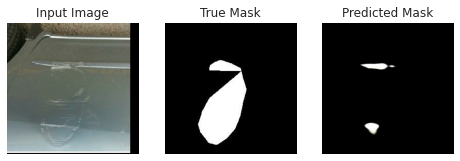


Sample Prediction after epoch 7


Epoch 00007: val_dice_coef did not improve from 0.54903
49/49 [==============================] - 59s 1s/step - loss: 0.2479 - dice_coef: 0.7521 - val_loss: 0.4550 - val_dice_coef: 0.5450
Epoch 8/50
49/49 [==============================] - ETA: 0s - loss: 0.2449 - dice_coef: 0.7551

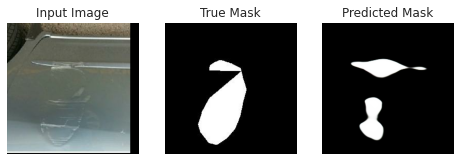


Sample Prediction after epoch 8


Epoch 00008: val_dice_coef did not improve from 0.54903
49/49 [==============================] - 59s 1s/step - loss: 0.2449 - dice_coef: 0.7551 - val_loss: 0.6254 - val_dice_coef: 0.3746
Epoch 9/50
49/49 [==============================] - ETA: 0s - loss: 0.2116 - dice_coef: 0.7884

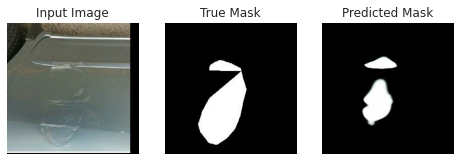


Sample Prediction after epoch 9


Epoch 00009: val_dice_coef improved from 0.54903 to 0.55014, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 60s 1s/step - loss: 0.2116 - dice_coef: 0.7884 - val_loss: 0.4499 - val_dice_coef: 0.5501
Epoch 10/50
49/49 [==============================] - ETA: 0s - loss: 0.1913 - dice_coef: 0.8087

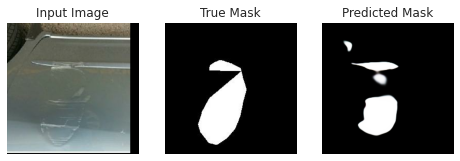


Sample Prediction after epoch 10


Epoch 00010: val_dice_coef did not improve from 0.55014
49/49 [==============================] - 59s 1s/step - loss: 0.1913 - dice_coef: 0.8087 - val_loss: 0.5594 - val_dice_coef: 0.4406
Epoch 11/50
49/49 [==============================] - ETA: 0s - loss: 0.1851 - dice_coef: 0.8149

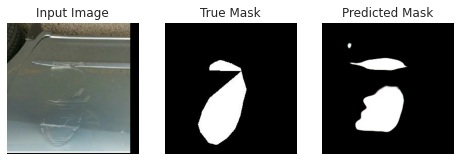


Sample Prediction after epoch 11


Epoch 00011: val_dice_coef improved from 0.55014 to 0.66191, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 59s 1s/step - loss: 0.1851 - dice_coef: 0.8149 - val_loss: 0.3381 - val_dice_coef: 0.6619
Epoch 12/50
49/49 [==============================] - ETA: 0s - loss: 0.1722 - dice_coef: 0.8278

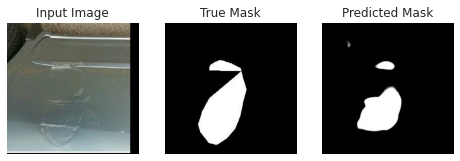


Sample Prediction after epoch 12


Epoch 00012: val_dice_coef improved from 0.66191 to 0.67676, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 59s 1s/step - loss: 0.1722 - dice_coef: 0.8278 - val_loss: 0.3232 - val_dice_coef: 0.6768
Epoch 13/50
49/49 [==============================] - ETA: 0s - loss: 0.1659 - dice_coef: 0.8341

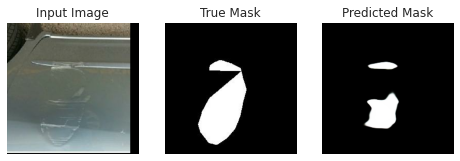


Sample Prediction after epoch 13


Epoch 00013: val_dice_coef improved from 0.67676 to 0.68976, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 60s 1s/step - loss: 0.1659 - dice_coef: 0.8341 - val_loss: 0.3102 - val_dice_coef: 0.6898
Epoch 14/50
49/49 [==============================] - ETA: 0s - loss: 0.1517 - dice_coef: 0.8483

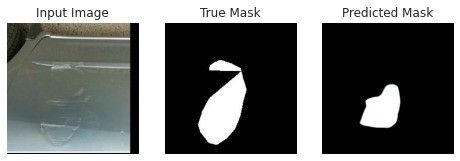


Sample Prediction after epoch 14


Epoch 00014: val_dice_coef improved from 0.68976 to 0.71054, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 59s 1s/step - loss: 0.1517 - dice_coef: 0.8483 - val_loss: 0.2895 - val_dice_coef: 0.7105
Epoch 15/50
49/49 [==============================] - ETA: 0s - loss: 0.1465 - dice_coef: 0.8535

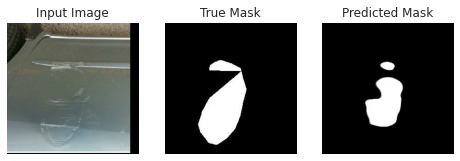


Sample Prediction after epoch 15


Epoch 00015: val_dice_coef did not improve from 0.71054
49/49 [==============================] - 59s 1s/step - loss: 0.1465 - dice_coef: 0.8535 - val_loss: 0.3204 - val_dice_coef: 0.6796
Epoch 16/50
49/49 [==============================] - ETA: 0s - loss: 0.1458 - dice_coef: 0.8542

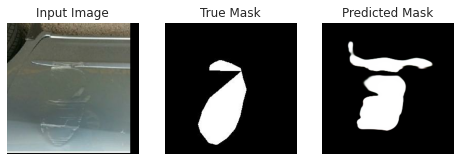


Sample Prediction after epoch 16


Epoch 00016: val_dice_coef did not improve from 0.71054
49/49 [==============================] - 59s 1s/step - loss: 0.1458 - dice_coef: 0.8542 - val_loss: 0.3389 - val_dice_coef: 0.6611
Epoch 17/50
49/49 [==============================] - ETA: 0s - loss: 0.1495 - dice_coef: 0.8505

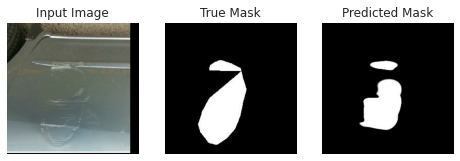


Sample Prediction after epoch 17


Epoch 00017: val_dice_coef did not improve from 0.71054
49/49 [==============================] - 59s 1s/step - loss: 0.1495 - dice_coef: 0.8505 - val_loss: 0.3853 - val_dice_coef: 0.6147
Epoch 18/50
49/49 [==============================] - ETA: 0s - loss: 0.1275 - dice_coef: 0.8725

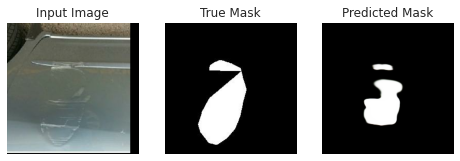


Sample Prediction after epoch 18


Epoch 00018: val_dice_coef did not improve from 0.71054
49/49 [==============================] - 59s 1s/step - loss: 0.1275 - dice_coef: 0.8725 - val_loss: 0.3147 - val_dice_coef: 0.6853
Epoch 19/50
49/49 [==============================] - ETA: 0s - loss: 0.1210 - dice_coef: 0.8790

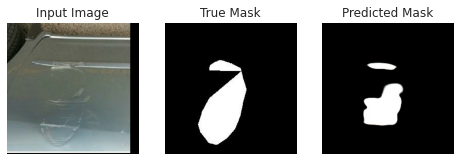


Sample Prediction after epoch 19


Epoch 00019: val_dice_coef improved from 0.71054 to 0.72668, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 60s 1s/step - loss: 0.1210 - dice_coef: 0.8790 - val_loss: 0.2733 - val_dice_coef: 0.7267
Epoch 20/50
49/49 [==============================] - ETA: 0s - loss: 0.1288 - dice_coef: 0.8712

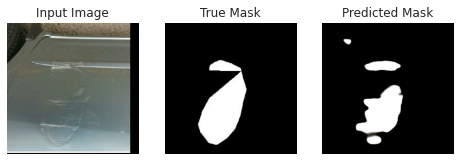


Sample Prediction after epoch 20


Epoch 00020: val_dice_coef did not improve from 0.72668
49/49 [==============================] - 59s 1s/step - loss: 0.1288 - dice_coef: 0.8712 - val_loss: 0.2808 - val_dice_coef: 0.7192
Epoch 21/50
49/49 [==============================] - ETA: 0s - loss: 0.1575 - dice_coef: 0.8425

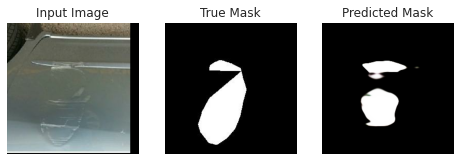


Sample Prediction after epoch 21


Epoch 00021: val_dice_coef did not improve from 0.72668
49/49 [==============================] - 59s 1s/step - loss: 0.1575 - dice_coef: 0.8425 - val_loss: 0.6333 - val_dice_coef: 0.3667
Epoch 22/50
49/49 [==============================] - ETA: 0s - loss: 0.1338 - dice_coef: 0.8662

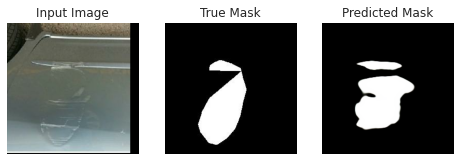


Sample Prediction after epoch 22


Epoch 00022: val_dice_coef did not improve from 0.72668
49/49 [==============================] - 59s 1s/step - loss: 0.1338 - dice_coef: 0.8662 - val_loss: 0.3566 - val_dice_coef: 0.6434
Epoch 23/50
49/49 [==============================] - ETA: 0s - loss: 0.1247 - dice_coef: 0.8753

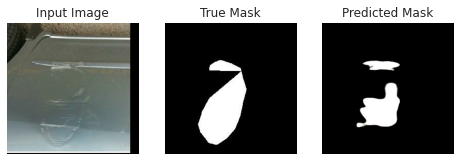


Sample Prediction after epoch 23


Epoch 00023: val_dice_coef did not improve from 0.72668
49/49 [==============================] - 59s 1s/step - loss: 0.1247 - dice_coef: 0.8753 - val_loss: 0.2947 - val_dice_coef: 0.7053
Epoch 24/50
49/49 [==============================] - ETA: 0s - loss: 0.1295 - dice_coef: 0.8705

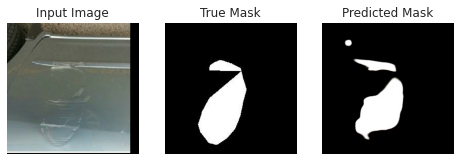


Sample Prediction after epoch 24


Epoch 00024: val_dice_coef improved from 0.72668 to 0.74601, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 59s 1s/step - loss: 0.1295 - dice_coef: 0.8705 - val_loss: 0.2540 - val_dice_coef: 0.7460
Epoch 25/50
49/49 [==============================] - ETA: 0s - loss: 0.1187 - dice_coef: 0.8813

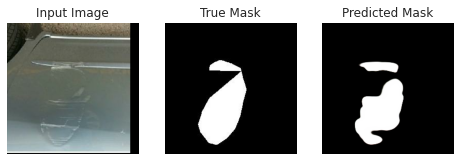


Sample Prediction after epoch 25


Epoch 00025: val_dice_coef did not improve from 0.74601
49/49 [==============================] - 59s 1s/step - loss: 0.1187 - dice_coef: 0.8813 - val_loss: 0.3767 - val_dice_coef: 0.6233
Epoch 26/50
49/49 [==============================] - ETA: 0s - loss: 0.1061 - dice_coef: 0.8939

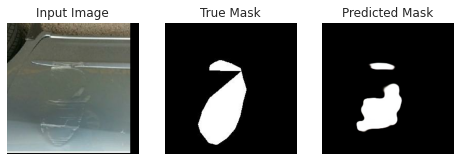


Sample Prediction after epoch 26


Epoch 00026: val_dice_coef did not improve from 0.74601
49/49 [==============================] - 59s 1s/step - loss: 0.1061 - dice_coef: 0.8939 - val_loss: 0.2551 - val_dice_coef: 0.7449
Epoch 27/50
49/49 [==============================] - ETA: 0s - loss: 0.1040 - dice_coef: 0.8960

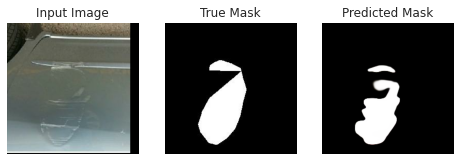


Sample Prediction after epoch 27


Epoch 00027: val_dice_coef did not improve from 0.74601
49/49 [==============================] - 59s 1s/step - loss: 0.1040 - dice_coef: 0.8960 - val_loss: 0.3231 - val_dice_coef: 0.6769
Epoch 28/50
49/49 [==============================] - ETA: 0s - loss: 0.1032 - dice_coef: 0.8968

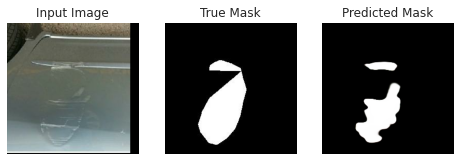


Sample Prediction after epoch 28


Epoch 00028: val_dice_coef did not improve from 0.74601
49/49 [==============================] - 59s 1s/step - loss: 0.1032 - dice_coef: 0.8968 - val_loss: 0.2602 - val_dice_coef: 0.7398
Epoch 29/50
49/49 [==============================] - ETA: 0s - loss: 0.0934 - dice_coef: 0.9066

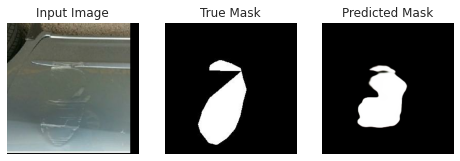


Sample Prediction after epoch 29


Epoch 00029: val_dice_coef improved from 0.74601 to 0.75032, saving model to /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5
49/49 [==============================] - 60s 1s/step - loss: 0.0934 - dice_coef: 0.9066 - val_loss: 0.2497 - val_dice_coef: 0.7503
Epoch 30/50
49/49 [==============================] - ETA: 0s - loss: 0.1057 - dice_coef: 0.8943

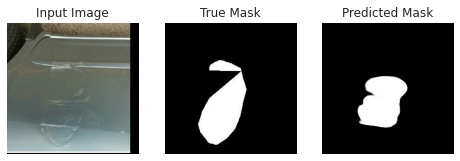


Sample Prediction after epoch 30


Epoch 00030: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.1057 - dice_coef: 0.8943 - val_loss: 0.2975 - val_dice_coef: 0.7025
Epoch 31/50
49/49 [==============================] - ETA: 0s - loss: 0.0934 - dice_coef: 0.9066

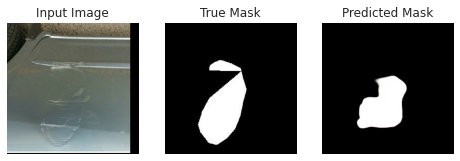


Sample Prediction after epoch 31


Epoch 00031: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0934 - dice_coef: 0.9066 - val_loss: 0.2927 - val_dice_coef: 0.7073
Epoch 32/50
49/49 [==============================] - ETA: 0s - loss: 0.0909 - dice_coef: 0.9091

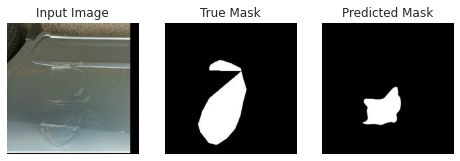


Sample Prediction after epoch 32


Epoch 00032: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0909 - dice_coef: 0.9091 - val_loss: 0.3504 - val_dice_coef: 0.6496
Epoch 33/50
49/49 [==============================] - ETA: 0s - loss: 0.0795 - dice_coef: 0.9205

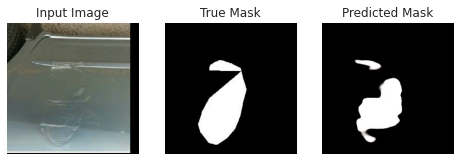


Sample Prediction after epoch 33


Epoch 00033: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0795 - dice_coef: 0.9205 - val_loss: 0.3470 - val_dice_coef: 0.6530
Epoch 34/50
49/49 [==============================] - ETA: 0s - loss: 0.0849 - dice_coef: 0.9151

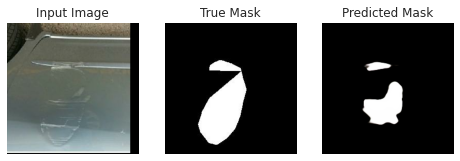


Sample Prediction after epoch 34


Epoch 00034: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0849 - dice_coef: 0.9151 - val_loss: 0.2979 - val_dice_coef: 0.7021
Epoch 35/50
49/49 [==============================] - ETA: 0s - loss: 0.0833 - dice_coef: 0.9167

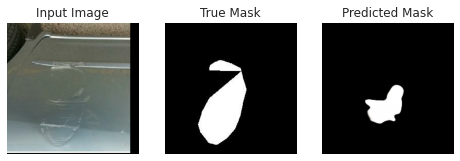


Sample Prediction after epoch 35


Epoch 00035: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0833 - dice_coef: 0.9167 - val_loss: 0.3386 - val_dice_coef: 0.6614
Epoch 36/50
49/49 [==============================] - ETA: 0s - loss: 0.0884 - dice_coef: 0.9116

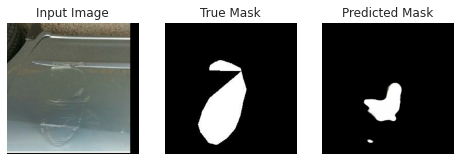


Sample Prediction after epoch 36


Epoch 00036: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0884 - dice_coef: 0.9116 - val_loss: 0.5034 - val_dice_coef: 0.4966
Epoch 37/50
49/49 [==============================] - ETA: 0s - loss: 0.0838 - dice_coef: 0.9162

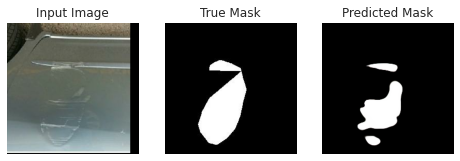


Sample Prediction after epoch 37


Epoch 00037: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0838 - dice_coef: 0.9162 - val_loss: 0.3389 - val_dice_coef: 0.6611
Epoch 38/50
49/49 [==============================] - ETA: 0s - loss: 0.0765 - dice_coef: 0.9235

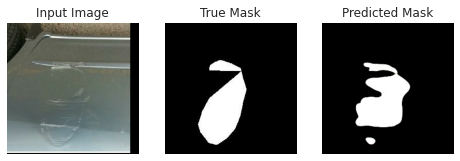


Sample Prediction after epoch 38


Epoch 00038: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0765 - dice_coef: 0.9235 - val_loss: 0.3830 - val_dice_coef: 0.6170
Epoch 39/50
49/49 [==============================] - ETA: 0s - loss: 0.0778 - dice_coef: 0.9222

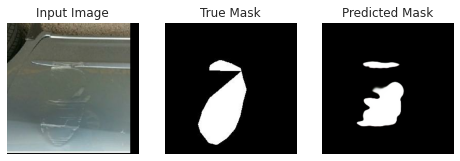


Sample Prediction after epoch 39


Epoch 00039: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0778 - dice_coef: 0.9222 - val_loss: 0.4851 - val_dice_coef: 0.5149
Epoch 40/50
49/49 [==============================] - ETA: 0s - loss: 0.0733 - dice_coef: 0.9267

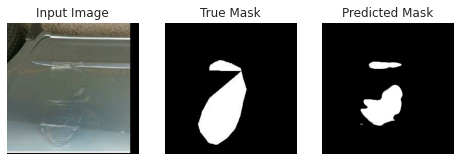


Sample Prediction after epoch 40


Epoch 00040: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0733 - dice_coef: 0.9267 - val_loss: 0.3103 - val_dice_coef: 0.6897
Epoch 41/50
49/49 [==============================] - ETA: 0s - loss: 0.0786 - dice_coef: 0.9214

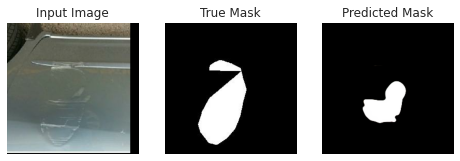


Sample Prediction after epoch 41


Epoch 00041: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0786 - dice_coef: 0.9214 - val_loss: 0.4767 - val_dice_coef: 0.5233
Epoch 42/50
49/49 [==============================] - ETA: 0s - loss: 0.0697 - dice_coef: 0.9303

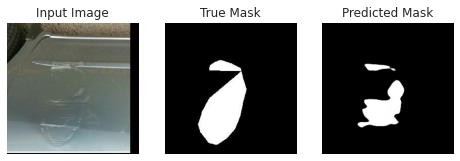


Sample Prediction after epoch 42


Epoch 00042: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0697 - dice_coef: 0.9303 - val_loss: 0.2556 - val_dice_coef: 0.7444
Epoch 43/50
49/49 [==============================] - ETA: 0s - loss: 0.0715 - dice_coef: 0.9285

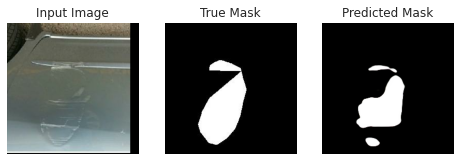


Sample Prediction after epoch 43


Epoch 00043: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0715 - dice_coef: 0.9285 - val_loss: 0.3095 - val_dice_coef: 0.6905
Epoch 44/50
49/49 [==============================] - ETA: 0s - loss: 0.0748 - dice_coef: 0.9252

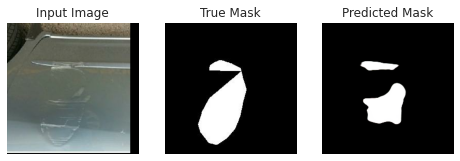


Sample Prediction after epoch 44


Epoch 00044: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0748 - dice_coef: 0.9252 - val_loss: 0.3399 - val_dice_coef: 0.6601
Epoch 45/50
49/49 [==============================] - ETA: 0s - loss: 0.0868 - dice_coef: 0.9132

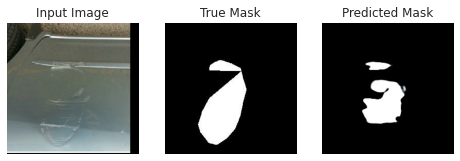


Sample Prediction after epoch 45


Epoch 00045: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0868 - dice_coef: 0.9132 - val_loss: 0.3374 - val_dice_coef: 0.6626
Epoch 46/50
49/49 [==============================] - ETA: 0s - loss: 0.0683 - dice_coef: 0.9317

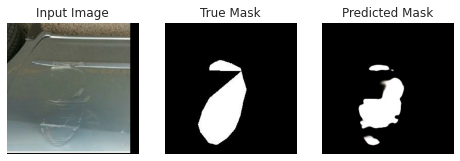


Sample Prediction after epoch 46


Epoch 00046: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0683 - dice_coef: 0.9317 - val_loss: 0.3020 - val_dice_coef: 0.6980
Epoch 47/50
49/49 [==============================] - ETA: 0s - loss: 0.0603 - dice_coef: 0.9397

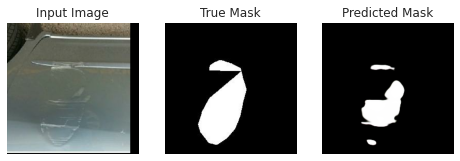


Sample Prediction after epoch 47


Epoch 00047: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0603 - dice_coef: 0.9397 - val_loss: 0.2964 - val_dice_coef: 0.7036
Epoch 48/50
49/49 [==============================] - ETA: 0s - loss: 0.0545 - dice_coef: 0.9455

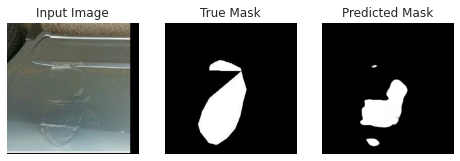


Sample Prediction after epoch 48


Epoch 00048: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0545 - dice_coef: 0.9455 - val_loss: 0.5330 - val_dice_coef: 0.4670
Epoch 49/50
49/49 [==============================] - ETA: 0s - loss: 0.0613 - dice_coef: 0.9387

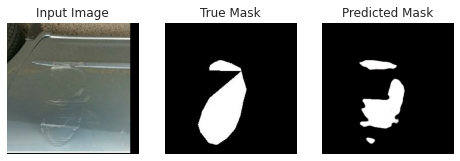


Sample Prediction after epoch 49


Epoch 00049: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0613 - dice_coef: 0.9387 - val_loss: 0.3895 - val_dice_coef: 0.6105
Epoch 50/50
49/49 [==============================] - ETA: 0s - loss: 0.0551 - dice_coef: 0.9449

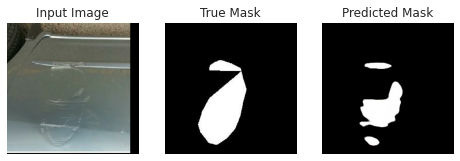


Sample Prediction after epoch 50


Epoch 00050: val_dice_coef did not improve from 0.75032
49/49 [==============================] - 59s 1s/step - loss: 0.0551 - dice_coef: 0.9449 - val_loss: 0.3035 - val_dice_coef: 0.6965


In [0]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 5//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit_generator(tf_image_generator, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_tf_image_generator,
                          callbacks=[DisplayCallback(), mc, tensorboard])

### Plotting Losses

### TensorBoard

<img src="images/tensorboard_unet++.PNG">

Sample predictions



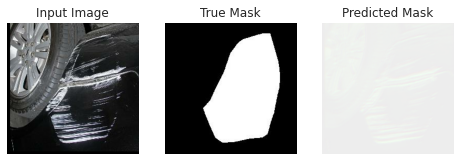

In [0]:
# Loading best model
model = Nested_UNet(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer, loss=sm.losses.dice_loss, metrics=[dice_coef])
print('Sample predictions\n')
show_predictions()
model.load_weights('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_new.h5')

In [0]:
# Save the entire model as a SavedModel.
model.save('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_Nested_unet5')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_Nested_unet4/assets


In [0]:
model = load_model('/content/drive/My Drive/Colab Notebooks/CS2/references/car_damage_final_Nested_unet4', custom_objects=dependencies)

## 6. Predictions

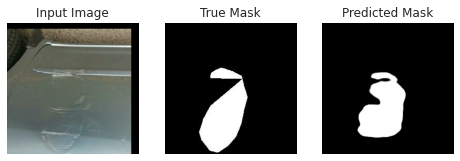

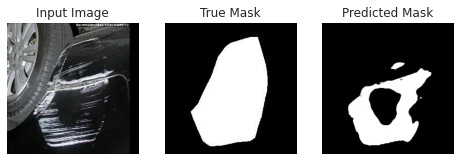

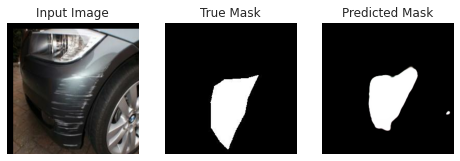

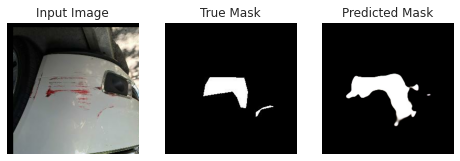

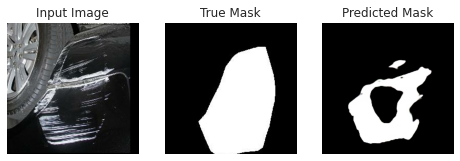

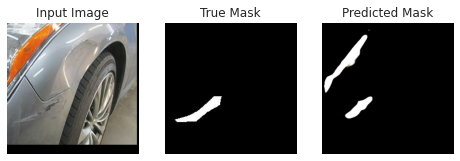

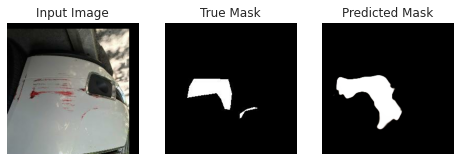

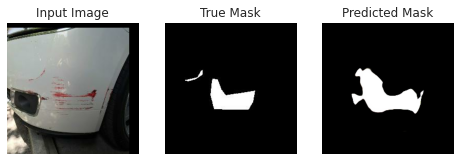

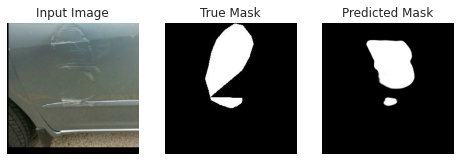

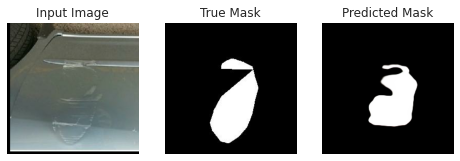

In [0]:
for image, mask in val_tf_image_generator.take(10):
  sample_image, sample_mask = image[0], mask[0]
  display1([sample_image, sample_mask,
         model.predict(sample_image[tf.newaxis, ...])[0]])

### Model comparsions

In [7]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Name", "train_dice_coef", "val_dice_coef"]

x.add_row(["U-Net", '0.89', '0.72'])
x.add_row(["Modified U-Net", '0.87', '0.76'])
x.add_row(["U-Net++", '0.87', '0.75'])
print(x)

+----------------+-----------------+---------------+
|   Model Name   | train_dice_coef | val_dice_coef |
+----------------+-----------------+---------------+
|     U-Net      |       0.89      |      0.72     |
| Modified U-Net |       0.87      |      0.76     |
|    U-Net++     |       0.87      |      0.75     |
+----------------+-----------------+---------------+


## 7. Conclusions and Future Research

1. I have experimented with U-net, modified U-net and U-net++ model for training on samll dataset (55 total images) which is giving good predictions.

2. Compared to U-net, U-net++, modified U-net are giving good predictions and the val_dice_coef is smooth.

3. Model trained on U-net architecture is overfitting compared to other models

4. Since the dataset is small we have to use datagenerator to improve performance and avoid overfitting.

5. Due to time constraint i was not unable to collect more images and do proper data preprocessing like masking damages properly, removing unnecesary images and croping to make the damage clear as ther are some full car pictures.

6. we can also try some of the techniques described in the tenosr flow tutorials https://www.tensorflow.org/tutorials/keras/overfit_and_underfit to avoid overfit